In [15]:
import pickle
import torch
import matplotlib.pyplot as plt

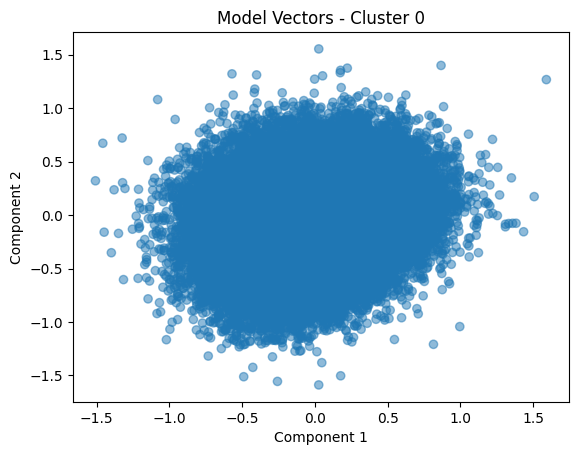

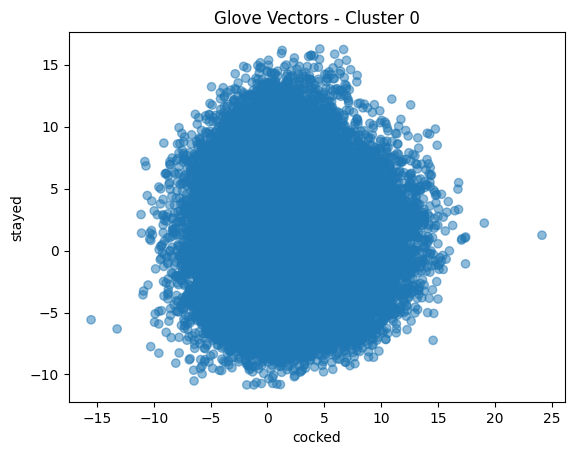

FileNotFoundError: [Errno 2] No such file or directory: './projectors/closest_words-1.pkl'

In [19]:
# Load the data about the clusters
_, data = pickle.load(open("./glove/kmeans_clusters_500.pkl", "rb"))

# Check if GPU(s) are available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

save_dir = "./projectors/"

X, labels = None, None
for key in data.keys():
    if X is None:
        X = torch.Tensor(data[key])
        labels = torch.reshape(torch.Tensor([key] * len(data[key])), (-1, 1))
    else:
        X = torch.cat([X, torch.Tensor(data[key])])
        temp = torch.reshape(torch.Tensor([key] * len(data[key])), (-1, 1))
        labels = torch.cat([labels, temp])

# Create the set of unique labels
targets = [x.item() for x in labels]
unique_labels = list(set(targets))

for j in unique_labels:
    glove_vectors = []
    model_vectors = []  
    words = []
    
    # One hot the labels
    targets = [1 if x == j else 0 for x in targets]
    X_temp = X[torch.Tensor(targets) == 1]
    
    explanations = pickle.load(open(save_dir + f"closest_words-{int(j)}.pkl", "rb"))
    for exp in explanations.values():
        glove_vectors.append(exp["glove vector"])
        model_vectors.append(exp["produced vector"])
        words.append(exp["word"])
        
    # Model vectors is a k length list of d dimensional vectors
    # Turn it into a k x d tensor
    model_vectors = torch.Tensor(model_vectors)
    glove_vectors = torch.Tensor(glove_vectors)
    
    glove_vectors = (glove_vectors.reshape(glove_vectors.shape[0], -1))
    
    y = model_vectors.T
    model_vector_projection_matrix = y @ (y.T @ y).inverse() @ y.T
    
    y = glove_vectors.T
    glove_vector_projection_matrix = y @ (y.T @ y).inverse() @ y.T
    
    # Project X
    X_model = model_vector_projection_matrix @ X.T
    X_glove = glove_vector_projection_matrix @ X.T
    
    X_model = X_model.T
    X_glove = X_glove.T
    
    # Reduce vectors in X_model into combinations of the model_vectors
    X_model = X_model @ model_vectors.T
    
    # Reduce vectors in X_glove into combinations of the glove_vectors
    X_glove = X_glove @ glove_vectors.T
    
    # Plot the reduced vectors
    fig, ax = plt.subplots()
    ax.scatter(X_model[:, 0], X_model[:, 1], c=targets, cmap='tab20', alpha=0.5)
    # Set the axes labels
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_title(f"Model Vectors - Cluster {int(j)}")
    plt.savefig(save_dir + f"projector-{int(j)}-model.png")
    plt.show()
    
    fig, ax = plt.subplots()
    ax.scatter(X_glove[:, 0], X_glove[:, 1], c=targets, cmap='tab20', alpha=0.5)
    # Set the axes labels
    ax.set_xlabel(words[0])
    ax.set_ylabel(words[1])
    ax.set_title(f"Glove Vectors - Cluster {int(j)}")
    plt.savefig(save_dir + f"projector-{int(j)}-glove.png")
    plt.show()
    